<a href="https://colab.research.google.com/github/JumanaRahim/workshop/blob/master/LUNG_NODULE_DETECTION_vgg11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pretrainedmodels
!pip install torchsummary
!pip install imutils
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 7.0 MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=66f197e99606dadb3bfa9cd289cb0fa2b749048501b1b4357bea97c0e7b8b3fa
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfully built pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from torchsummary import summary
from torch import nn
import torch.nn.functional as F
from imutils import paths
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pretrainedmodels
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
!unzip /content/drive/MyDrive/dataset.zip

Archive:  /content/drive/MyDrive/dataset.zip
   creating: dataset/benign/
  inflating: dataset/benign/JPCLN002.png  
  inflating: dataset/benign/JPCLN004.png  
  inflating: dataset/benign/JPCLN006.png  
  inflating: dataset/benign/JPCLN008.png  
  inflating: dataset/benign/JPCLN011.png  
  inflating: dataset/benign/JPCLN013.png  
  inflating: dataset/benign/JPCLN024.png  
  inflating: dataset/benign/JPCLN025.png  
  inflating: dataset/benign/JPCLN026.png  
  inflating: dataset/benign/JPCLN030.png  
  inflating: dataset/benign/JPCLN034.png  
  inflating: dataset/benign/JPCLN036.png  
  inflating: dataset/benign/JPCLN043.png  
  inflating: dataset/benign/JPCLN048.png  
  inflating: dataset/benign/JPCLN049.png  
  inflating: dataset/benign/JPCLN055.png  
  inflating: dataset/benign/JPCLN058.png  
  inflating: dataset/benign/JPCLN060.png  
  inflating: dataset/benign/JPCLN061.png  
  inflating: dataset/benign/JPCLN066.png  
  inflating: dataset/benign/JPCLN068.png  
  inflating: dataset/be

In [ ]:
root='/content/dataset'

In [ ]:
classes=('benign', 'malignant', 'non-nodule')


In [ ]:
image_paths = list(paths.list_images('/content/dataset'))

data = []
labels = []
for img_path in image_paths:
    label = img_path.split(os.path.sep)[-2]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    data.append(img)
    labels.append(label)
    
data = np.array(data)
labels = np.array(labels)

In [ ]:
labels

array(['malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'malignant',
       'malignant', 'malignant', 'malignant', 'malignant', 'mali

In [ ]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
print(f"Total Number of Classes: {len(lb.classes_)}")

Total Number of Classes: 3


In [ ]:
#orginal dataset

train_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

test_orginal_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])    


#for data augmentation

train_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

test_augmentation_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean = [0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [ ]:
# divide the data into train, validation, and test set
#(X, x_val , Y, y_val) = train_test_split(data, labels, test_size=0.2,  stratify=labels,random_state=42)
#(x_train, x_test, y_train, y_test) = train_test_split(X, Y, test_size=0.25, random_state=42)
#print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.3,random_state=42)
print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}")

x_train examples: (172, 2048, 2048, 3)
x_test examples: (75, 2048, 2048, 3)


In [ ]:
batch_size=6

In [ ]:
# custom dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transforms = None):
        self.labels = labels
        self.images = images
        self.transforms = transforms
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        data = self.images[index][:]
        labels = self.labels[index]
        
        if self.transforms:
            data = self.transforms(data)
            
            return data,labels

        
        
        
        
train_orginal_data = CustomDataset(x_train, y_train, train_orginal_transforms)
test_orginal_data = CustomDataset(x_test, y_test, test_orginal_transforms)     


train_augmentation_data = CustomDataset(x_train, y_train, train_augmentation_transforms )
test_augmentation_data = CustomDataset(x_test, y_test, test_augmentation_transforms )  

train_data = torch.utils.data.ConcatDataset([train_orginal_data,train_augmentation_data])
print(len(train_data))
test_data = torch.utils.data.ConcatDataset([test_orginal_data,test_augmentation_data])
print(len(test_data))




trainLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
testLoader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4) 

344
150


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for X, y in trainLoader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([6, 3, 224, 224])
Shape of y: torch.Size([6]) torch.int64


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# **MODEL**

In [ ]:
# the vgg11 model
class vgg11(nn.Module):
    def __init__(self, pretrained):
        super(vgg11, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['vgg11'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['vgg11'](pretrained = None)
        # change the classification layer
        self.l0= nn.Linear(4096, len(lb.classes_))
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        # get the batch size only, ignore(c, h, w)
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        #x = self.dropout(x)
        l0 = self.l0(x)
        return l0

model = vgg11(pretrained=True).to(device)
print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

vgg11(
  (model): VGG(
    (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
    (_features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): R

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = vgg11(pretrained=True).to(device)

#model.load_state_dict(torch.load("/kaggle/working/model.pth", map_location= device))

model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
              ReLU-8          [-1, 256, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         590,080
             ReLU-10          [-1, 256, 56, 56]               0
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
             ReLU-13          [-1, 512, 28, 28]               0
           Conv2d-14          [-1, 512,

# **OPTIMZER**

In [ ]:
lr = 0.001

WEIGHT_DECAY = 0.0005
save_path = "model.pth"
fine_tune = True
#load_path = "/kaggle/working/model_1.pth"

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay=WEIGHT_DECAY)
optimizer= torch.optim.SGD(model.parameters(),lr= lr,momentum=0.9)

# **LOAD MODEL**

In [ ]:
#state_dict = torch.load(load_path, map_location=device)
#model.load_state_dict(state_dict)

# **TRAINING**

In [ ]:
def train(model,dataloader):    
    # training function

    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    total=0
    for batch, (X, y) in enumerate(tqdm(dataloader)):


        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        outputs = model(X)
        loss = loss_fn(outputs, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += (outputs.argmax(1) == y).type(torch.float).sum().item()
        total += y.size(0)

    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    #print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")


    return loss, accuracy

# **VALIDATION**

In [ ]:
#validation function
def validate(model, dataloader):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total=0
    with torch.no_grad():
        
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)
            running_loss += loss_fn(pred, y).item()        
            running_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            total += y.size(0)
        
    loss = running_loss/len(dataloader)
    accuracy = 100.*running_correct/total
    #print(f'Val Loss: {loss:.4f}, Val Acc: {accuracy:.2f}')
    print('Test Loss: %.3f | Accuracy: %.3f'%(loss, accuracy))


    return loss, accuracy

# **TRAINING AND VALIDATION IN SINGLE FUNCTION**

In [ ]:
epochs=50


train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = train(model, trainLoader)
    val_epoch_loss, val_epoch_accuracy = validate(model, testLoader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

Training on 344 examples, validating on 150 examples...
Epoch 1 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.15it/s]

Train Loss: 1.289 | Accuracy: 38.081
Validating


Test Loss: 1.084 | Accuracy: 37.333
Epoch 2 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.40it/s]

Train Loss: 1.069 | Accuracy: 41.570
Validating


Test Loss: 1.110 | Accuracy: 36.000
Epoch 3 of 50
Training


100%|██████████| 58/58 [00:10<00:00,  5.59it/s]

Train Loss: 1.000 | Accuracy: 50.581
Validating


Test Loss: 1.030 | Accuracy: 41.333
Epoch 4 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.11it/s]

Train Loss: 0.913 | Accuracy: 61.337
Validating


Test Loss: 1.123 | Accuracy: 44.667
Epoch 5 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.30it/s]

Train Loss: 0.921 | Accuracy: 53.779
Validating


Test Loss: 1.017 | Accuracy: 48.000
Epoch 6 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.38it/s]

Train Loss: 0.854 | Accuracy: 61.047
Validating


Test Loss: 1.012 | Accuracy: 48.667
Epoch 7 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.35it/s]

Train Loss: 0.775 | Accuracy: 65.988
Validating


Test Loss: 1.010 | Accuracy: 49.333
Epoch 8 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.16it/s]

Train Loss: 0.724 | Accuracy: 68.314
Validating


Test Loss: 0.992 | Accuracy: 52.667
Epoch 9 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.33it/s]

Train Loss: 0.548 | Accuracy: 76.163
Validating


Test Loss: 1.080 | Accuracy: 55.333
Epoch 10 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.34it/s]

Train Loss: 0.616 | Accuracy: 74.419
Validating


Test Loss: 1.109 | Accuracy: 49.333
Epoch 11 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.40it/s]

Train Loss: 0.497 | Accuracy: 77.035
Validating


Test Loss: 1.063 | Accuracy: 58.667
Epoch 12 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.36it/s]

Train Loss: 0.501 | Accuracy: 79.651
Validating


Test Loss: 1.169 | Accuracy: 58.667
Epoch 13 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.42it/s]

Train Loss: 0.434 | Accuracy: 81.686
Validating


Test Loss: 1.151 | Accuracy: 56.000
Epoch 14 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.42it/s]

Train Loss: 0.314 | Accuracy: 86.628
Validating


Test Loss: 1.326 | Accuracy: 48.667
Epoch 15 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.39it/s]

Train Loss: 0.257 | Accuracy: 90.988
Validating


Test Loss: 1.473 | Accuracy: 54.667
Epoch 16 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.37it/s]

Train Loss: 0.170 | Accuracy: 93.314
Validating


Test Loss: 1.818 | Accuracy: 56.667
Epoch 17 of 50
Training


100%|██████████| 58/58 [00:12<00:00,  4.50it/s]

Train Loss: 0.360 | Accuracy: 86.047
Validating


Test Loss: 1.217 | Accuracy: 48.667
Epoch 18 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.36it/s]

Train Loss: 0.200 | Accuracy: 93.895
Validating


Test Loss: 1.321 | Accuracy: 55.333
Epoch 19 of 50
Training


100%|██████████| 58/58 [00:08<00:00,  6.47it/s]

Train Loss: 0.162 | Accuracy: 95.058
Validating


Test Loss: 1.419 | Accuracy: 59.333
Epoch 20 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.34it/s]

Train Loss: 0.158 | Accuracy: 93.023
Validating


Test Loss: 1.996 | Accuracy: 48.667
Epoch 21 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.42it/s]

Train Loss: 0.082 | Accuracy: 97.093
Validating


Test Loss: 1.749 | Accuracy: 60.667
Epoch 22 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.33it/s]

Train Loss: 0.146 | Accuracy: 94.477
Validating


Test Loss: 1.550 | Accuracy: 55.333
Epoch 23 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.42it/s]

Train Loss: 0.136 | Accuracy: 95.930
Validating


Test Loss: 2.033 | Accuracy: 54.667
Epoch 24 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.40it/s]

Train Loss: 0.157 | Accuracy: 93.895
Validating


Test Loss: 1.933 | Accuracy: 56.000
Epoch 25 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.33it/s]

Train Loss: 0.234 | Accuracy: 91.279
Validating


Test Loss: 1.363 | Accuracy: 57.333
Epoch 26 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.38it/s]

Train Loss: 0.242 | Accuracy: 89.535
Validating


Test Loss: 1.491 | Accuracy: 49.333
Epoch 27 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.40it/s]

Train Loss: 0.096 | Accuracy: 96.221
Validating


Test Loss: 1.889 | Accuracy: 58.667
Epoch 28 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.11it/s]

Train Loss: 0.079 | Accuracy: 97.965
Validating


Test Loss: 2.195 | Accuracy: 52.667
Epoch 29 of 50
Training


100%|██████████| 58/58 [00:08<00:00,  6.45it/s]

Train Loss: 0.173 | Accuracy: 93.895
Validating


Test Loss: 1.399 | Accuracy: 64.000
Epoch 30 of 50
Training


100%|██████████| 58/58 [00:08<00:00,  6.47it/s]

Train Loss: 0.101 | Accuracy: 97.093
Validating


Test Loss: 1.714 | Accuracy: 59.333
Epoch 31 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.37it/s]

Train Loss: 0.023 | Accuracy: 99.419
Validating


Test Loss: 1.913 | Accuracy: 56.667
Epoch 32 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.38it/s]

Train Loss: 0.040 | Accuracy: 98.547
Validating


Test Loss: 2.316 | Accuracy: 58.000
Epoch 33 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.33it/s]

Train Loss: 0.040 | Accuracy: 98.256
Validating


Test Loss: 2.331 | Accuracy: 59.333
Epoch 34 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.24it/s]

Train Loss: 0.084 | Accuracy: 97.093
Validating


Test Loss: 2.321 | Accuracy: 51.333
Epoch 35 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.40it/s]

Train Loss: 0.050 | Accuracy: 98.547
Validating


Test Loss: 2.232 | Accuracy: 55.333
Epoch 36 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.36it/s]

Train Loss: 0.010 | Accuracy: 100.000
Validating


Test Loss: 2.517 | Accuracy: 53.333
Epoch 37 of 50
Training


100%|██████████| 58/58 [00:11<00:00,  5.24it/s]

Train Loss: 0.014 | Accuracy: 99.419
Validating


Test Loss: 2.257 | Accuracy: 56.000
Epoch 38 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.31it/s]

Train Loss: 0.021 | Accuracy: 99.709
Validating


Test Loss: 2.427 | Accuracy: 56.667
Epoch 39 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.32it/s]

Train Loss: 0.026 | Accuracy: 99.419
Validating


Test Loss: 2.121 | Accuracy: 59.333
Epoch 40 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.27it/s]

Train Loss: 0.031 | Accuracy: 99.128
Validating


Test Loss: 2.620 | Accuracy: 59.333
Epoch 41 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.34it/s]

Train Loss: 0.069 | Accuracy: 97.965
Validating


Test Loss: 2.198 | Accuracy: 56.000
Epoch 42 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.41it/s]

Train Loss: 0.019 | Accuracy: 99.709
Validating


Test Loss: 2.213 | Accuracy: 59.333
Epoch 43 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.36it/s]

Train Loss: 0.011 | Accuracy: 99.709
Validating


Test Loss: 2.224 | Accuracy: 62.000
Epoch 44 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.37it/s]

Train Loss: 0.016 | Accuracy: 99.128
Validating


Test Loss: 2.071 | Accuracy: 66.000
Epoch 45 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.25it/s]

Train Loss: 0.006 | Accuracy: 100.000
Validating


Test Loss: 2.181 | Accuracy: 60.667
Epoch 46 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.35it/s]

Train Loss: 0.017 | Accuracy: 99.709
Validating


Test Loss: 2.485 | Accuracy: 58.667
Epoch 47 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.37it/s]

Train Loss: 0.039 | Accuracy: 98.256
Validating


Test Loss: 2.407 | Accuracy: 58.000
Epoch 48 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.41it/s]

Train Loss: 0.011 | Accuracy: 99.709
Validating


Test Loss: 2.290 | Accuracy: 57.333
Epoch 49 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.36it/s]

Train Loss: 0.005 | Accuracy: 100.000
Validating


Test Loss: 2.572 | Accuracy: 56.667
Epoch 50 of 50
Training


100%|██████████| 58/58 [00:09<00:00,  6.35it/s]

Train Loss: 0.005 | Accuracy: 100.000
Validating


Test Loss: 2.314 | Accuracy: 58.667


# **MODEL SAVING**

In [ ]:
torch.save(model.state_dict(), save_path)
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [ ]:
model = vgg11(pretrained=True).to(device)
#model.load_state_dict(torch.load("model.pth"))

state_dict = torch.load(f"/content/{save_path}")
model.load_state_dict(state_dict)

<All keys matched successfully>

# **VISUALIZE PREDICTING IMAGE**

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def imageshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    # get batch of images from the test DataLoader  
    images, labels = next(iter(testLoader))

    # show all images as one image grid
    imageshow(torchvision.utils.make_grid(images))
   
    # Show the real labels on the screen 
    print('Real labels: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(batch_size)))
  
    # Let's see what if the model identifiers the  labels of those example
    images=images.to(device)
    outputs = model(images)
    
    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)
    
    # Let's show the predicted labels on the screen to compare with the real ones
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(batch_size)))

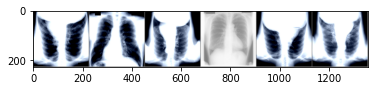

Real labels:  benign benign malignant benign non-nodule benign
Predicted:  benign benign malignant malignant benign benign


In [ ]:
testBatch()

# **PLOT ACCURACY**

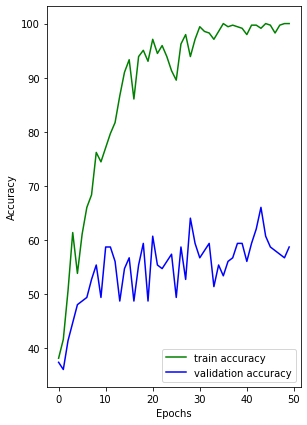

In [ ]:
# accuracy plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('../outputs/plots/accuracy.png')


# **PLOT LOSS**

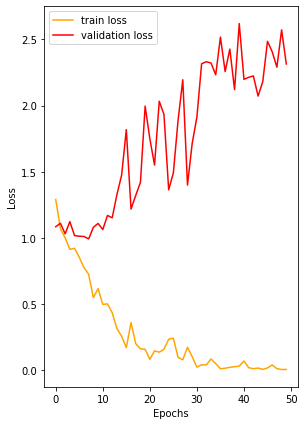

In [ ]:
# loss plots
plt.figure(figsize=(10, 7))
plt.subplot(121)
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('../outputs/plots/loss.png')
plt.show()

In [ ]:
label2class ={ 1 :'benign', 2 :'malignant', 3:'non-nodule'}


In [ ]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for batch,(inputs, labels) in enumerate(testLoader):
    
    
        inputs= inputs.to(device)
        labels= labels.to(device)
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
        

report = classification_report(y_true, y_pred)
print(report)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


              precision    recall  f1-score   support

           0       0.56      0.59      0.57        34
           1       0.57      0.54      0.55        54
           2       0.71      0.73      0.72        62

    accuracy                           0.63       150
   macro avg       0.61      0.62      0.61       150
weighted avg       0.63      0.63      0.63       150



Text(0.5, 204.0, 'Predicted label')

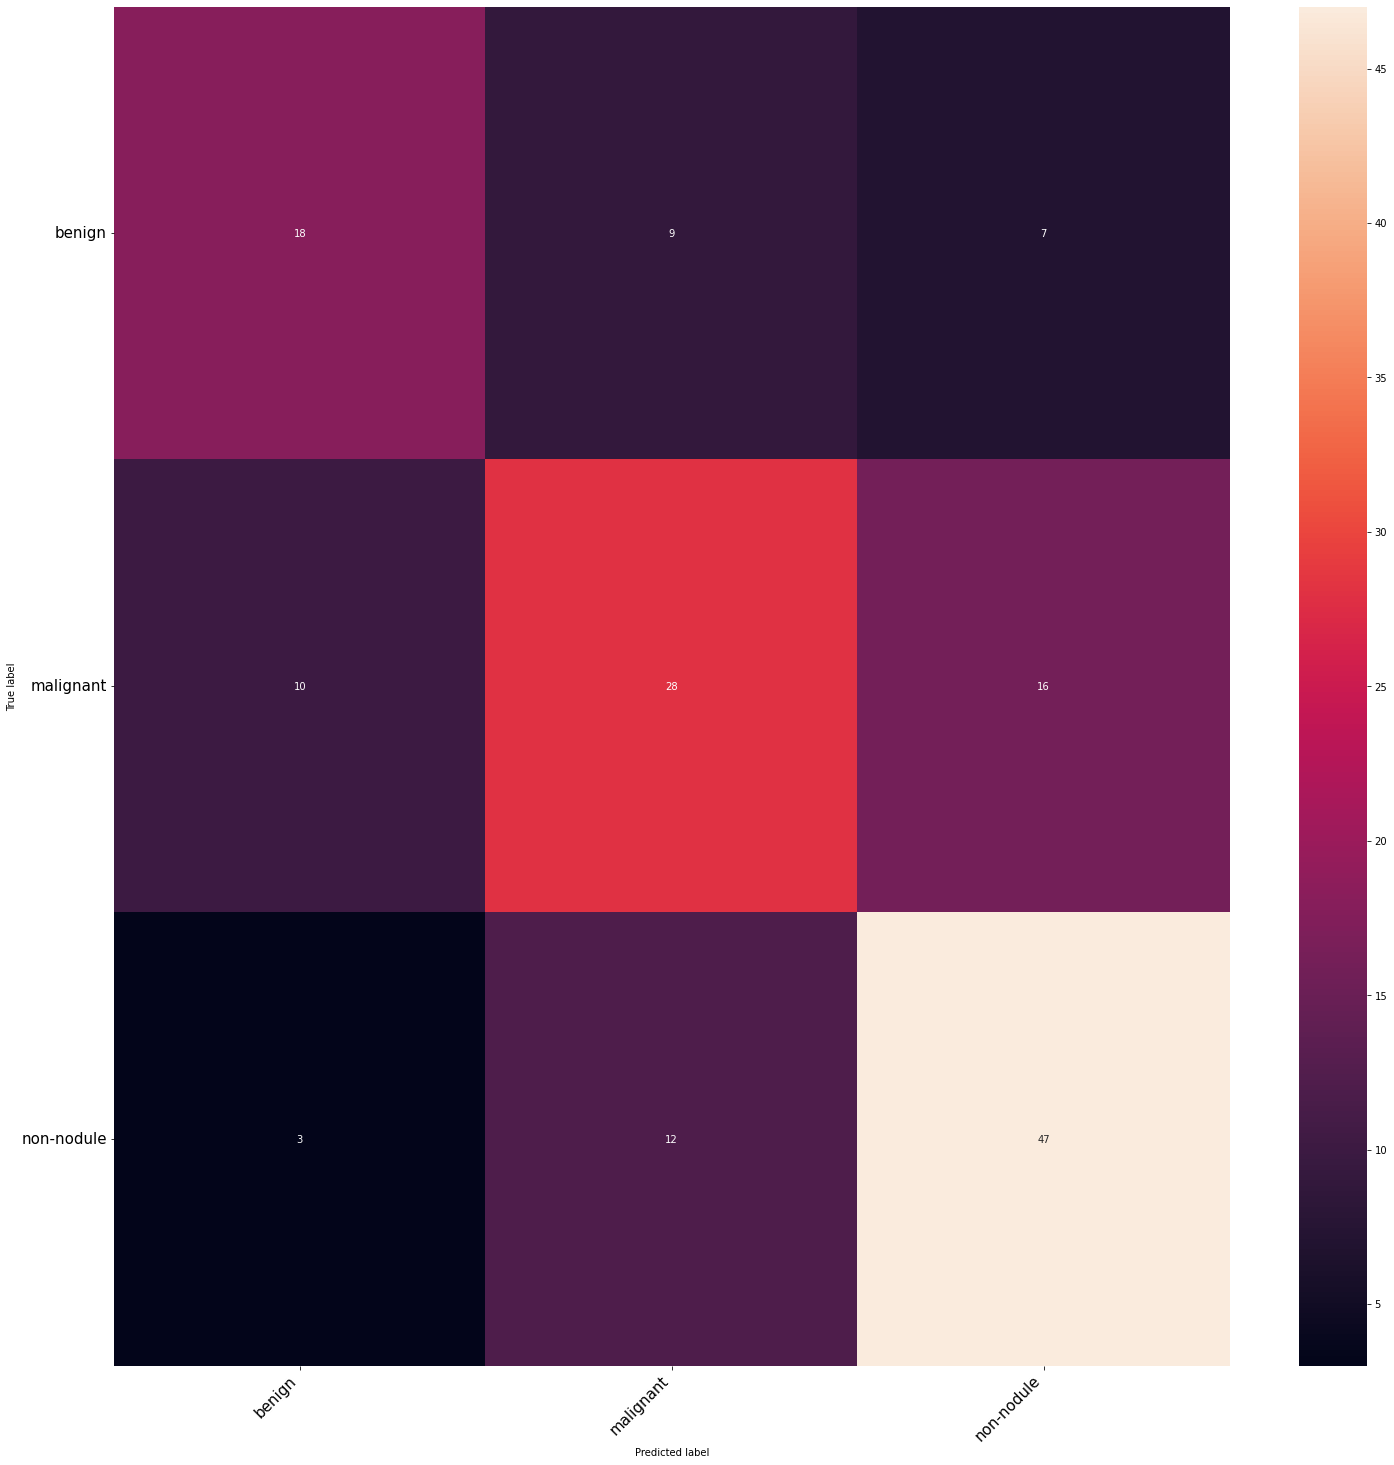

In [ ]:
nb_classes = 3
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testLoader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(25,25))

class_names = list(label2class.values())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')